In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import multiprocessing
import gc

data_cfg = {
    'Input_param_names': ['ambient',
                          'coolant',
                          'u_d',
                          'u_q',
                          'motor_speed',
                          #'torque',
                          'i_d',
                          'i_q'
                           ],
    'Target_param_names': ['pm',
                           'stator_yoke',
                           'stator_tooth',
                           'stator_winding'
                          ],
    # for ewm and statistical moments
    'drop': None,  #[p for p in range(40, 400)],  #['46', '47'],
    'downsample_rate': 1,
    'rolling_lookback': [120,600,3600,7200],
    'valset' : [78, 79, 81],
    'testset' : [27, 29, 30, 31, 65, 72, 4,  5,  6],
    'loss': 'mse',
    # profile ids to drop (don't need to actually exist)

    # paths
    'file_path': "measures.csv",
    'db_path': 'results.db',
    'model_dump_path': 'output/',
    'save_predictions': True,
    'random_seed': 2019,
    'downsample_val_test': True,
    'db_target_scheme': ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
}

# Load dataset
path = 'measures.csv'
conversion_table = {col: np.float32 for col in data_cfg['Input_param_names'] + data_cfg['Target_param_names']}
conversion_table.update({'profile_id': np.uint8})
dataset = pd.read_csv(path, dtype=conversion_table)

# Drop specified profiles if any
if data_cfg['drop'] is not None:
    drop_p_l = [int(p) for p in data_cfg['drop']]
    dataset.drop(index=dataset[dataset['profile_id'].isin(drop_p_l)].index, inplace=True)

# Select relevant columns
x_cols = data_cfg['Input_param_names']
y_cols = data_cfg['Target_param_names']
dataset = dataset.loc[:, x_cols + y_cols + ['profile_id']]

# Create time column
# dataset['time'] = dataset.groupby('profile_id').cumcount() * 0.5

# Create extra features
def calculate_i_s(row):
    return np.sqrt(row['i_d']**2 + row['i_q']**2)

def calculate_u_s(row):
    return np.sqrt(row['u_d']**2 + row['u_q']**2)

def calculate_P_el(row):
    return row['i_s'] * row['u_s']

if set(['i_d', 'i_q', 'u_d', 'u_q']).issubset(set(dataset.columns.tolist())):
    dataset['i_s'] = dataset.apply(calculate_i_s, axis=1)
    dataset['u_s'] = dataset.apply(calculate_u_s, axis=1)
    dataset['P_el'] = dataset.apply(calculate_P_el, axis=1)

# Function to create lag features
def create_lag_features(args):
    df, lookback = args
    dfs = []
    for lback in range(lookback, lookback + 1, lookback):
        lag_feats = [
            df.shift(lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}'),
            df.diff(periods=lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}_diff')
        ]
        lag_feats += [
            abs(lag_feats[1]).astype(np.float32).add_suffix('_abs'),
            pd.DataFrame(df.values + lag_feats[0].values, columns=df.columns).add_suffix(f'_sum')
        ]
        dfs.append(pd.concat(lag_feats, axis=1))
    return pd.concat(dfs, axis=1)

# Function to create rolling features
def create_rolling_features(args):
    df, lookbacks = args
    dfs = []
    for lookback in lookbacks:
        dummy = np.zeros((lookback, len(df.columns)))
        dummy = pd.DataFrame(dummy, columns=df.columns)
        df = pd.concat([dummy, df], axis=0, ignore_index=True)
        ew_mean = pd.concat([df.ewm(span=lookback).mean().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_mean_' + str(lookback))], axis=1)
        ew_std = pd.concat([df.ewm(span=lookback).std().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_std_' + str(lookback))], axis=1)
        dfs.append(pd.concat([ew_mean, ew_std], axis=1).iloc[lookback + 1:, :].reset_index(drop=True))
    return pd.concat(dfs, axis=1)

# Apply feature creation in parallel
profiles_df = [dataset.loc[dataset['profile_id'] == int(p), :].reset_index(drop=True) for p in dataset['profile_id'].unique().tolist()]
with multiprocessing.Pool(2) as pool:
    lag_feats = pool.map(create_lag_features, [(df, data_cfg['downsample_rate']) for df in profiles_df])
    rolling_feats = pool.map(create_rolling_features, [(df, data_cfg['rolling_lookback']) for df in profiles_df])

# Merge features together
merged_profiles_df = [pd.concat([df] + [lag_feats[i], rolling_feats[i]], axis=1) for i, df in enumerate(profiles_df)]
dataset = pd.concat(merged_profiles_df, axis=0, ignore_index=True)

# Standardize the data
scaler = StandardScaler()
float_cols = x_cols + y_cols
dataset[float_cols] = scaler.fit_transform(dataset[float_cols].astype(float))

# Clean up
gc.collect()

# Save or return the processed dataset
dataset.to_csv('processed_dataset_base.csv', index=False)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = dataset.columns
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
x_cols = x_cols[~x_cols.isin(y_cols)]

# x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
# y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']


2025-03-17 23:33:32.033522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742234612.080099    4975 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742234612.093537    4975 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742234612.190375    4975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742234612.190400    4975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742234612.190402    4975 computation_placer.cc:177] computation placer alr

In [2]:
x_cols

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q',
       'profile_id', 'i_s', 'u_s',
       ...
       'i_d_ew_rolling_std_7200', 'i_q_ew_rolling_std_7200',
       'pm_ew_rolling_std_7200', 'stator_yoke_ew_rolling_std_7200',
       'stator_tooth_ew_rolling_std_7200',
       'stator_winding_ew_rolling_std_7200', 'profile_id_ew_rolling_std_7200',
       'i_s_ew_rolling_std_7200', 'u_s_ew_rolling_std_7200',
       'P_el_ew_rolling_std_7200'],
      dtype='object', length=191)

In [3]:

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
# lookback = 10  
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

In [4]:
import numpy as np

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())


NaN in X_train: 46236517
NaN in y_train: 9308
Inf in X_train: 0
Inf in y_train: 0


In [5]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0


In [ ]:
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 60
NaNs in y_val: 0


In [7]:
X_val = np.nan_to_num(X_val)  # Replace NaNs with 0
y_val = np.nan_to_num(y_val)
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 0
NaNs in y_val: 0


In [10]:
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_test: 240
NaNs in y_val: 0


In [11]:
X_test = np.nan_to_num(X_test)  # Replace NaNs with 0
y_test = np.nan_to_num(y_test)
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_test:", np.isnan(y_test).sum())

NaNs in X_test: 0
NaNs in y_test: 0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 191)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │     24,512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 64)   │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 64)   │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 128, 64)   │     12,288 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128, 64)   │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 128, 64)   │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 64)   │          0 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_5[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ global_max_pooli… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,340 (212.27 KB)

 Trainable params: 53,956 (210.77 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100


2025-03-17 23:45:24.118333: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1017134592 exceeds 10% of free system memory.


326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 771513088.0000 - rmse: 2.4748 - val_loss: 320978784.0000 - val_rmse: 1.5426
Epoch 2/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 275121248.0000 - rmse: 1.9355 - val_loss: 158864192.0000 - val_rmse: 1.4914
Epoch 3/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 139426272.0000 - rmse: 1.8122 - val_loss: 94943048.0000 - val_rmse: 1.4705
Epoch 4/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 81981672.0000 - rmse: 1.7633 - val_loss: 65438224.0000 - val_rmse: 1.4395
Epoch 5/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 54015852.0000 - rmse: 1.7324 - val_loss: 49489988.0000 - val_rmse: 1.4007
Epoch 6/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 39124868.0000 - rmse: 1.7105 - val_loss: 39362976.0000 - val_rmse: 1.3586
Epoch 7/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 30945034.0000 - rmse: 1.6941 - val_loss: 32075290.0000 - val_rmse: 1.3265
Epoch 8/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step -

Test Loss: 1265.2910, Test RMSE: 0.9350


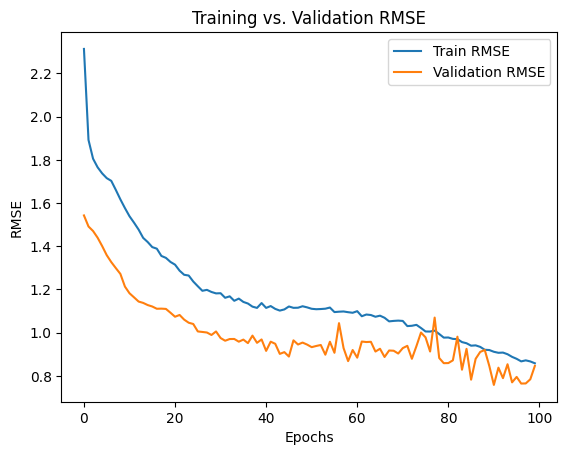

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# CNN Model
def build_cnn_model(x_shape, arch='plain', n_layers=3, n_units=64, activation='relu', 
                    kernel_size=3, dilation_start_rate=1, regularization_rate=1e-4, 
                    dropout_rate=0.3, optimizer='adam', lr_rate=5e-5, loss='mse', n_outputs=4):
    assert arch in ['plain', 'res'], "Specified architecture not recognized!"

    opts_map = {
        'adam': optimizers.Adam, 'nadam': optimizers.Nadam, 
        'adamax': optimizers.Adamax, 'sgd': optimizers.SGD, 
        'rmsprop': optimizers.RMSprop
    }

    # Model Configuration
    cnn_cfg = {
        'x_shape': x_shape, 'arch': arch, 'n_filters': int(n_units), 
        'kernel_size': int(kernel_size), 'dilation_start_rate': int(dilation_start_rate), 
        'n_layers': int(n_layers), 'activation': activation, 'dropout_rate': dropout_rate, 
        'reg_rate': regularization_rate, 'batchnorm': activation != 'selu', 
        'n_outputs': n_outputs
    }

    model = cnn_network(**cnn_cfg)

    opt = opts_map[optimizer](learning_rate=lr_rate)
    model.compile(optimizer=opt, loss=loss, metrics=[rmse])
    model.summary()
    return model

# CNN Network with Residual Option
def cnn_network(x_shape, arch, n_filters, kernel_size, dilation_start_rate,
                n_layers, activation, dropout_rate=0.5, reg_rate=1e-6,
                batchnorm=True, n_outputs=4):
    
    regs = {
        'kernel_regularizer': regularizers.l2(reg_rate),
        'bias_regularizer': regularizers.l2(reg_rate),
        'activity_regularizer': regularizers.l2(reg_rate)
    }

    def add_common_layers(z):
        if batchnorm:
            z = layers.BatchNormalization()(z)
        z = layers.Activation(activation)(z)
        z = layers.Dropout(dropout_rate)(z)  
        return z

    x = layers.Input(shape=x_shape)
    y = x  

    for i in range(n_layers):
        dilation_rate = dilation_start_rate * (2 ** i)

        if i % 2 == 0 and arch == 'res':
            shortcut = y  

        y = layers.Conv1D(n_filters, kernel_size, padding='causal', 
                          dilation_rate=dilation_rate, activation=None, **regs)(y)
        y = add_common_layers(y)

        if i % 2 == 1 and arch == 'res':
            shortcut = layers.Conv1D(n_filters, kernel_size=1, padding='causal', 
                                     activation=None, **regs)(shortcut)
            y = layers.add([shortcut, y])

    y = layers.GlobalMaxPooling1D()(y)
    y = layers.Dense(n_outputs)(y)  

    model = models.Model(inputs=x, outputs=y)
    return model

# Build CNN Model
cnn_model = build_cnn_model(x_shape=(lookback, len(x_cols)), arch='res', 
                            n_layers=3, n_units=64, activation='relu', 
                            kernel_size=2, dilation_start_rate=1, 
                            regularization_rate=1e-4, dropout_rate=0.3, 
                            optimizer='adam', lr_rate=5e-5, loss='mse', 
                            n_outputs=len(y_cols))

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, mode='min')

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, 
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate model
test_loss, test_rmse = cnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}')

# Save model
cnn_model.save('cnn_time_series_model.h5')
import json

# Save the history dictionary to a JSON file
with open("training_history_cnn_time_series_model.json", "w") as f:
    json.dump(history.history, f)

# Plot RMSE over epochs
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs. Validation RMSE')
plt.show()

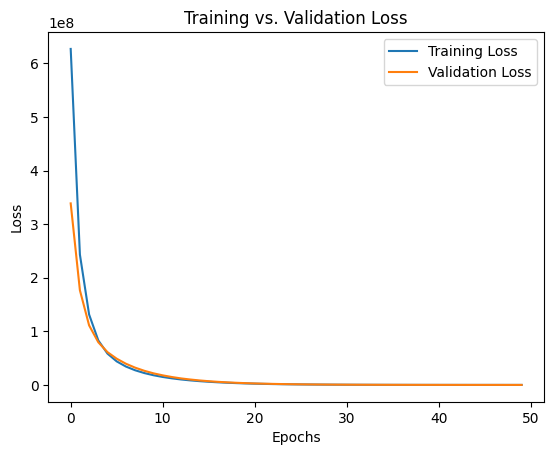

In [9]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


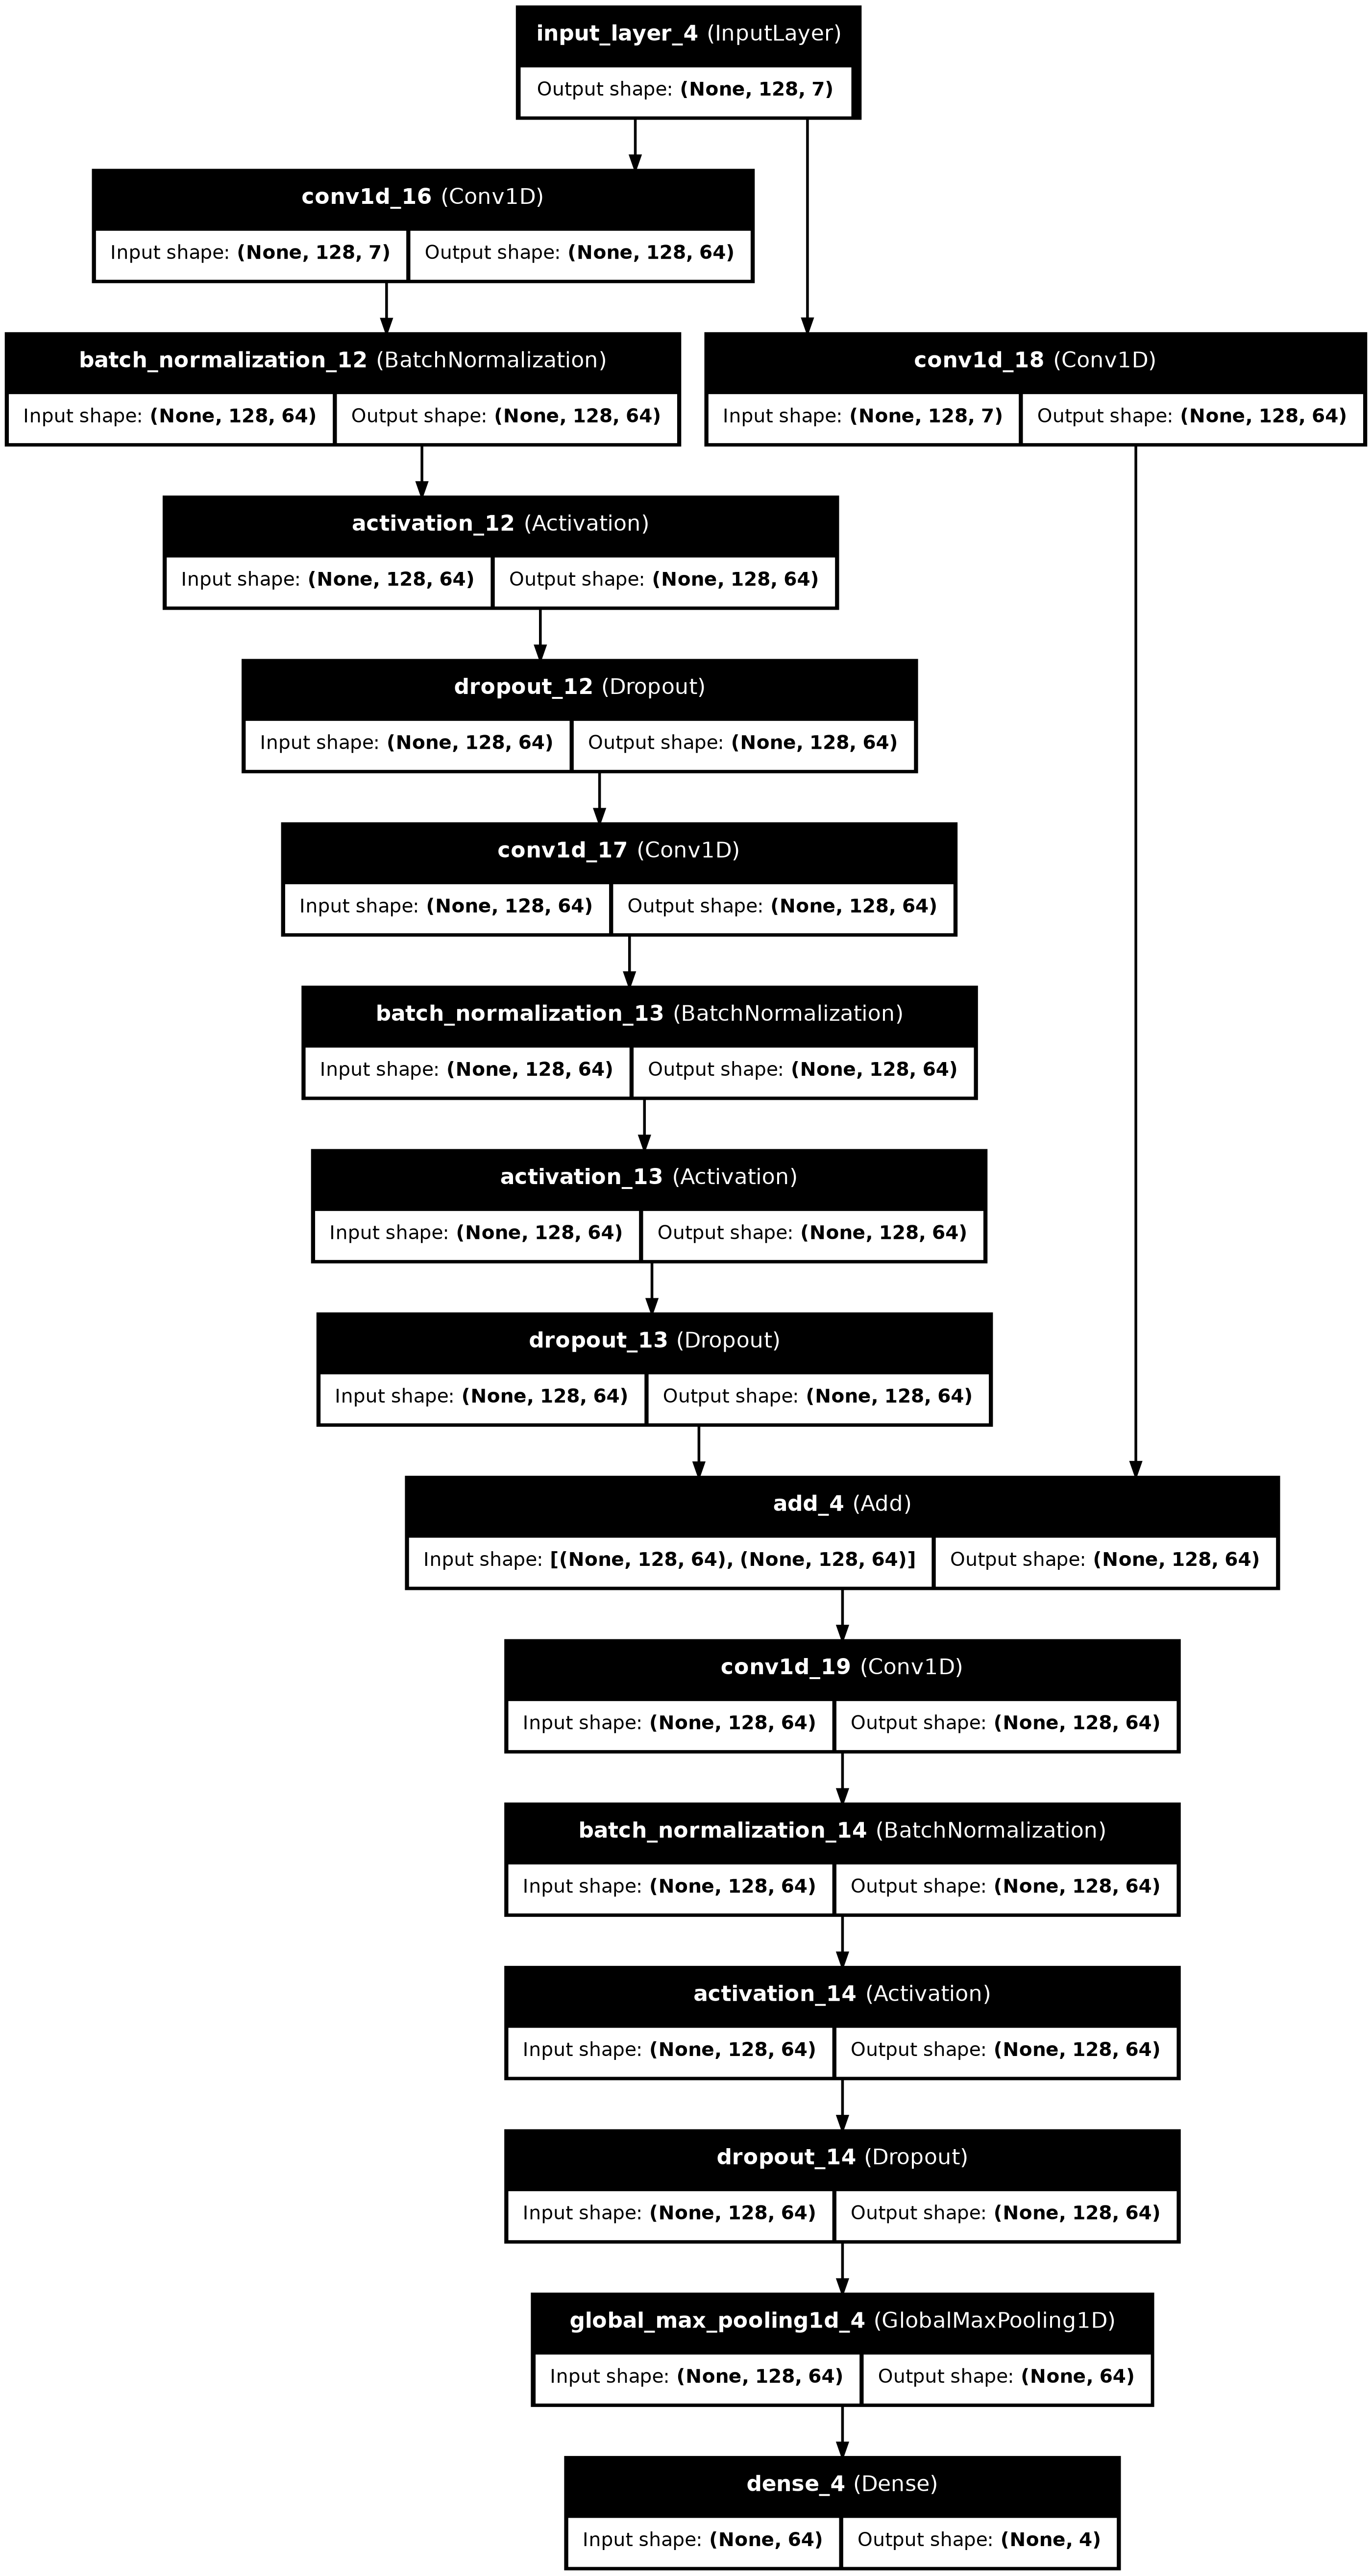

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(cnn_model, show_shapes=True, show_layer_names=True, to_file='cnn_model.png')


In [7]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc
import pickle
from sklearn.utils import resample

# Load the dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define the 7 basic input features
basic_x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

# Prepare the dataset using only basic features
X = dataset[basic_x_cols]
y = dataset[y_cols]

# Ensure time series integrity by splitting using profile_id
train_profiles = dataset['profile_id'].unique().tolist()
for test_id in [78, 79, 81]:  
    if test_id in train_profiles:
        train_profiles.remove(test_id)

# Keep DataFrame properties (don't convert to NumPy)
X_train = X[dataset['profile_id'].isin(train_profiles)].copy()
y_train = y[dataset['profile_id'].isin(train_profiles)].copy()
X_test = X[dataset['profile_id'].isin([78, 79, 81])].copy()
y_test = y[dataset['profile_id'].isin([78, 79, 81])].copy()

# Handle missing values directly in DataFrame
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

# Initialize SHAP values dictionary
shap_values_dict = {}

# Train and analyze SHAP for each target variable
for target in y_cols:
    print(f"Training model for {target}...")
    
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=2019)
    model.fit(X_train, y_train[target])  # Now y_train is still a DataFrame, no indexing error
    
    # Calculate SHAP values
    print(f"Calculating SHAP values for {target}...")
    explainer = shap.TreeExplainer(model)
    
    # Use a subset of test data for efficiency (use resample instead of .sample())
    sample_size = min(1000, X_test.shape[0])
    X_test_sample = resample(X_test, n_samples=sample_size, random_state=2019)
    
    # Compute SHAP values
    shap_values = explainer(X_test_sample).values
    shap_values_dict[target] = shap_values
    
    # Generate SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f"Feature Importance for {target} (Basic 7 Features)")
    plt.tight_layout()
    plt.savefig(f"basic7/shap_summary_{target}_basic7.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Generate SHAP dependence plots for top 3 features
    feature_importance = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance)[-3:]  # Fix indexing
    top_features = [X_test_sample.columns[i] for i in top_features_idx]
    
    for feature in top_features:
        plt.figure(figsize=(8, 5))
        shap.dependence_plot(feature, shap_values, X_test_sample, show=False)
        plt.title(f"SHAP Dependence Plot for {target} - {feature}")
        plt.tight_layout()
        plt.savefig(f"basic7/shap_dependence_{target}_{feature}_basic7.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"Completed SHAP analysis for {target}")
    gc.collect()

# Save SHAP values for later use
with open('basic7/shap_values_basic7.pkl', 'wb') as f:
    pickle.dump(shap_values_dict, f)

print("SHAP analysis complete for basic 7 features. Results saved.")


Training model for pm...
Calculating SHAP values for pm...
Completed SHAP analysis for pm
Training model for stator_yoke...
Calculating SHAP values for stator_yoke...
Completed SHAP analysis for stator_yoke
Training model for stator_tooth...
Calculating SHAP values for stator_tooth...
Completed SHAP analysis for stator_tooth
Training model for stator_winding...
Calculating SHAP values for stator_winding...
Completed SHAP analysis for stator_winding
SHAP analysis complete for basic 7 features. Results saved.


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [8]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc
import pickle
from sklearn.utils import resample

# Load the dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Use all available input features except target variables
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
x_cols = [col for col in dataset.columns if col not in y_cols + ['profile_id']]  # Exclude targets and profile_id

# Prepare the dataset
X = dataset[x_cols]
y = dataset[y_cols]

# Ensure time series integrity by splitting using profile_id
train_profiles = dataset['profile_id'].unique().tolist()
for test_id in [78, 79, 81]:  
    if test_id in train_profiles:
        train_profiles.remove(test_id)

# Keep DataFrame properties (don't convert to NumPy)
X_train = X[dataset['profile_id'].isin(train_profiles)].copy()
y_train = y[dataset['profile_id'].isin(train_profiles)].copy()
X_test = X[dataset['profile_id'].isin([78, 79, 81])].copy()
y_test = y[dataset['profile_id'].isin([78, 79, 81])].copy()

# Handle missing values directly in DataFrame
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

# Initialize SHAP values dictionary
shap_values_dict = {}

# Train and analyze SHAP for each target variable
for target in y_cols:
    print(f"Training model for {target}...")
    
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=2019)
    model.fit(X_train, y_train[target])  # Now y_train is still a DataFrame, no indexing error
    
    # Calculate SHAP values
    print(f"Calculating SHAP values for {target}...")
    explainer = shap.TreeExplainer(model)
    
    # Use a subset of test data for efficiency (use resample instead of .sample())
    sample_size = min(1000, X_test.shape[0])
    X_test_sample = resample(X_test, n_samples=sample_size, random_state=2019)
    
    # Compute SHAP values
    shap_values = explainer(X_test_sample).values
    shap_values_dict[target] = shap_values
    
    # Generate SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f"Feature Importance for {target} (All Features)")
    plt.tight_layout()
    plt.savefig(f"shap_all/shap_summary_{target}_all.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Generate SHAP dependence plots for top 3 features
    feature_importance = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance)[-3:]  # Fix indexing
    top_features = [X_test_sample.columns[i] for i in top_features_idx]
    
    for feature in top_features:
        plt.figure(figsize=(8, 5))
        shap.dependence_plot(feature, shap_values, X_test_sample, show=False)
        plt.title(f"SHAP Dependence Plot for {target} - {feature}")
        plt.tight_layout()
        plt.savefig(f"shap_all/shap_dependence_{target}_{feature}_all.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"Completed SHAP analysis for {target}")
    gc.collect()

# Save SHAP values for later use
with open('shap_all/shap_values_all.pkl', 'wb') as f:
    pickle.dump(shap_values_dict, f)

print("SHAP analysis complete for all features. Results saved.")


Training model for pm...
Calculating SHAP values for pm...
Completed SHAP analysis for pm
Training model for stator_yoke...
Calculating SHAP values for stator_yoke...
Completed SHAP analysis for stator_yoke
Training model for stator_tooth...
Calculating SHAP values for stator_tooth...
Completed SHAP analysis for stator_tooth
Training model for stator_winding...
Calculating SHAP values for stator_winding...
Completed SHAP analysis for stator_winding
SHAP analysis complete for all features. Results saved.


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>